In [1]:
import os

import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import logging
import time
import tensorflow as tf

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#file_path = '/content/drive/MyDrive/boilers_drive/normalized_df.csv'

In [3]:
# Specify the file path of your CSV file
#file_path = 'normalized_df.csv'
file_path = 'boilers/normalized_df.csv'

# the current script directory
# the current working directory
#current_dir = os.getcwd()

# the path to the CSV file in the parent directory
#parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
#file_path = os.path.join(parent_dir, 'normalized_df.csv')

# Read the CSV file
data = pd.read_csv(file_path)

print("Imported data:")
print(data)

Imported data:
                        time    blr_mod_lvl  absorption  insulation  t_r_set  \
0        2022-10-01 00:00:00   0.000000e+00    0.503910   -7.457292     15.0   
1        2022-10-01 00:01:00   0.000000e+00    0.503910   -7.455208     15.0   
2        2022-10-01 00:02:00   0.000000e+00    0.518558   -7.487500     15.0   
3        2022-10-01 00:03:00   0.000000e+00    0.616207   -7.426042     15.0   
4        2022-10-01 00:04:00   0.000000e+00    0.699210   -7.425000     15.0   
...                      ...            ...         ...         ...      ...   
7331983  2023-04-30 23:55:00  2.871866e-119   -0.296880   -1.604167     17.0   
7331984  2023-04-30 23:56:00  1.914578e-119   -0.296880   -1.614583     17.0   
7331985  2023-04-30 23:57:00  1.276385e-119   -0.296880   -1.572917     17.0   
7331986  2023-04-30 23:58:00  8.509234e-120   -0.296880   -1.511458     17.0   
7331987  2023-04-30 23:59:00  5.672823e-120   -0.296880   -1.432203     17.0   

             t_out house

In [7]:
# Different houses in data
houses = data['house_id'].unique()
print("Different houses in data:")
print(houses)
print("Number of different houses:")
print(len(houses))

Different houses in data:
['home2' 'home9' 'home13' 'home14' 'home34' 'home46' 'home55' 'home67'
 'home86' 'home93' 'home101' 'home106' 'home110' 'home43' 'home63'
 'home53' 'home79' 'home90' 'home95' 'home5' 'home17' 'home47' 'home51'
 'home65' 'home77' 'home89' 'home111' 'home114']
Number of different houses:
28


In [8]:
house_datasets = {}
for house in houses:
    house_datasets[house] = data[data['house_id'] == house]

#print(house_datasets)

**Δημιουργία του encoder decoder transformer**

In [9]:
# positional encoding layer
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)


# positional embedding layer
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [10]:
# Attention layers
# These are all identical except for how the attention is configured

# base attention layer
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()


# cross attention layer
# (at the center of the Transformer is the cross-attention layer, it connects the encoder and decoder)
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


# global self attention layer
# (it is responsible for processing the context sequence, and propagating information along its length)
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


# causal self attention layer
# (it does a similar job as the global self attention layer, for the output sequence)
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x, use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [11]:
# feed forward network
# (the transformer also includes this point-wise feed-forward network in both the encoder and decoder)
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [12]:
# encoder layer
# (the encoder contains a stack of N encoder layers. Where each EncoderLayer contains
#   a GlobalSelfAttention and FeedForward layer)
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [13]:
# The Encoder
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)


  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    # Add dropout.
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [14]:
# decoder layer
# (the decoder's stack is slightly more complex, with each DecoderLayer containing
#   a CausalSelfAttention, a CrossAttention, and a FeedForward layer)
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [15]:
# The Decoder
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None


  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [16]:
# The Transformer
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()

    self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size, dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size, dropout_rate=dropout_rate)

    #self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    self.final_layer = tf.keras.layers.Dense(1)


  def call(self, inputs):  # Expecting only one input
    x = inputs
    context = self.encoder(x)
    x = self.decoder(x, context)
    logits = self.final_layer(x)
    try:
      del logits._keras_mask
    except AttributeError:
      pass
    return logits

**Preparing the data**

In [17]:
# the categories for prediction
final_category = 'blr_mod_lvl'
prediction_categories = ['absorption', 'insulation', 't_r_set', 't_out']


In [ ]:
import math

In [ ]:
# function to prepare data before use with transformer
def prepare_data(input, output, minutes_per_day=1440):
    days = len(output_data) // minutes_per_day
    # the data into a list of sub-lists, each containing one day's data
    input_data = [
        input[i * minutes_per_day:(i + 1) * minutes_per_day]
        for i in range(days)
    ]
    output_data = [
        output[i * minutes_per_day:(i + 1) * minutes_per_day]
        for i in range(days)
    ]
    input_data = input_data[:-1]
    output_data = output_data[1:]
    return input_data, output_data


In [18]:
# Filter data for the 'absorption' category
category = 'absorption'
filtered_data = data[['house_id', 'time', category]].copy()

# We have 1440 minutes per day
minutes_per_day = 1440
batch_size = 8 # Reduce the batch size, in case it helps !

# Function to create input-target pairs for a single house
def create_pairs(house_data, category, minutes_per_day=1440):
    house_data = house_data.sort_values(by='time')
    data = house_data[category].values
    days = len(data) // minutes_per_day
    data = data[:days * minutes_per_day].reshape((days, minutes_per_day))
    input_data = data[:-1]
    target_data = data[1:]
    return input_data, target_data

# Initialize lists to store input and target pairs
input_data_list, target_data_list = [], []

for house_id in houses:
    house_data = filtered_data[filtered_data['house_id'] == 'home14']
    input_data, target_data = create_pairs(house_data, category)
    input_data_list.append(input_data)
    target_data_list.append(target_data)

# Combine all houses' data
input_data = np.concatenate(input_data_list, axis=0)
target_data = np.concatenate(target_data_list, axis=0)

# Convert to TensorFlow datasets
dataset = tf.data.Dataset.from_tensor_slices((input_data, target_data))
dataset = dataset.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
# train - validation - test !!!(80-20, from 80 : 80-20)

# Define the Transformer model
#model = Transformer(num_layers=4, d_model=128, num_heads=8, dff=512, input_vocab_size=minutes_per_day,
#                    target_vocab_size=minutes_per_day, dropout_rate=0.1) # minutes_per_day = 1440
model = Transformer(num_layers=4, d_model=64, num_heads=4, dff=256, input_vocab_size=minutes_per_day,
                    target_vocab_size=minutes_per_day, dropout_rate=0.1) # minutes_per_day = 1440

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [34]:
# Evaluate the model to inspect shapes
predictions = model.predict(dataset.take(1)) # Get predictions for one batch
print("Shape of predictions:", predictions.shape)
print("Shape of target batch:", next(iter(dataset))[1].shape)

1/1 [==============================] - 4s 4s/step
Shape of predictions: (8, 1440, 1)
Shape of target batch: (8, 1440)


In [35]:
# Train the model
model.fit(dataset, epochs=10)

Epoch 1/10
599/599 [==============================] - 504s 723ms/step - loss: 35.1366 - mean_absolute_error: 4.8635
Epoch 2/10
599/599 [==============================] - 432s 721ms/step - loss: 31.1358 - mean_absolute_error: 4.4868
Epoch 3/10
599/599 [==============================] - 432s 721ms/step - loss: 28.2573 - mean_absolute_error: 4.1841
Epoch 4/10
599/599 [==============================] - 432s 721ms/step - loss: 24.7433 - mean_absolute_error: 3.8021
Epoch 5/10
599/599 [==============================] - 433s 722ms/step - loss: 20.8243 - mean_absolute_error: 3.3792
Epoch 6/10
599/599 [==============================] - 431s 719ms/step - loss: 17.4513 - mean_absolute_error: 2.9996
Epoch 7/10
599/599 [==============================] - 426s 712ms/step - loss: 15.4389 - mean_absolute_error: 2.7571
Epoch 8/10
599/599 [==============================] - 426s 711ms/step - loss: 13.2674 - mean_absolute_error: 2.4949
Epoch 9/10
599/599 [==============================] - 425s 709ms/step - 

In [38]:
# Seeing how good it predicts all the days
test_data = data[data['house_id'] == 'home14']
test_blr = test_data['blr_mod_lvl'].values
predict_blr = model.predict(dataset)

599/599 [==============================] - 167s 279ms/step


In [51]:
print(test_blr.shape)
print(predict_blr.shape)
last_day = test_blr[:1440]
print(last_day.shape)
last_day_pred = predict_blr[-1]
print(last_day_pred.shape)
last_day_pred = last_day_pred.reshape(-1)
print(last_day_pred.shape)

(248066,)
(4788, 1440, 1)
(1440,)
(1440, 1)
(1440,)


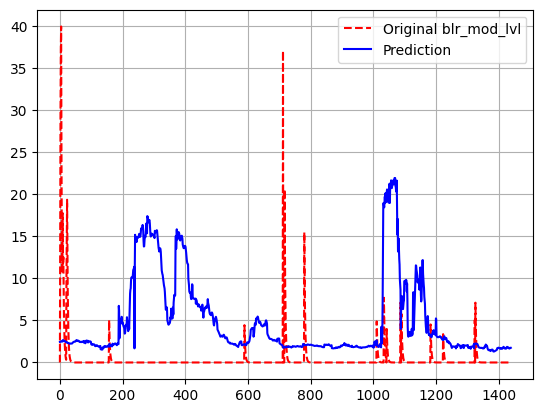

In [54]:
x = np.arange(len(last_day_pred))

# Create the plot
plt.plot(x, last_day, linestyle='--', color='r', label='Original blr_mod_lvl')
plt.plot(x, last_day_pred, linestyle='-', color='b', label='Prediction')

# Add a legend
plt.legend()

# Add a grid
plt.grid(True)

# Show the plot
plt.show()